# Import

In [1]:
from parcels import (
        FieldSet,
        JITParticle,
        ScipyParticle,
        ParticleSet,
        AdvectionRK4,
        AdvectionRK4_3D,
        StatusCode,
)
import parcels

import datetime as dt
from datetime import datetime, timedelta

import dask
from dask.distributed import Client

import numpy as np
from numpy.random import uniform, randint

from pathlib import Path
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cmocean

import xarray as xr
from glob import glob
import cartopy
import cartopy.crs as ccrs
import xoak
from time import time
import warnings
import shapely


warnings.simplefilter("ignore")

# Set Parameters

In [2]:
# Parameters
RNG_seed = 123

# Time
year = 2016
start_month = 1
start_day = 1
end_month = 12
end_day = 31
max_age_d = 220
# timedirection
timearrow = 1
# Timestep in minutes
dt_in_minutes = 15
output_dt_in_minutes = 15

# Box traits
depth_m = 0

n_particles_per_cell = 10

repeated_release = True
repeatdt_d = 7

isPapermill = False


In [3]:
if not isPapermill:
        year = 2016
        start_month = 1
        start_day = 1
        end_month = 1
        end_day = 2
        max_age_d = 200
        # timedirection
        timearrow = 1
        # Timestep in minutes
        dt_in_minutes = 3*60
        output_dt_in_minutes = 12*60

        # Box traits
        depth_m = 0

        n_particles_per_cell = 1

        repeated_release = False
        repeatdt_d = 7

# Read Files

In [4]:
# Get Variables from Parameters
start_date = np.datetime64(f"{year}-{start_month:02d}-{start_day:02d}", "D")
end_date = np.datetime64(f"{year}-{end_month:02d}-{end_day:02d}", "D")
first_day_in_year = np.datetime64(f"{year}-01-01", "D")

first_file_count = (start_date - first_day_in_year).astype(int) * 4
if first_file_count > 0:
        first_file_count -= 1

last_file_count = (end_date - first_day_in_year + 1).astype(int) * 4 + 1

runtime_in_days = (end_date - start_date).tolist()
dt_min = np.timedelta64(dt_in_minutes, "m").tolist()
dt_out_min = np.timedelta64(output_dt_in_minutes, "m").tolist()

np.random.seed(RNG_seed)
save_path = f"/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/{year}/"

## Get file names 

In [5]:
# establish folder paths
path_orig_files = Path("/gxfs_work/geomar/smomw400/bsh_operationalmodel_data/")
path_divz_files = Path("/gxfs_work/geomar/smomw122/bsh_operationalmodel_data/")
path_static_files = Path("/gxfs_work/geomar/smomw122/bsh_operationalmodel_data")
path_static_fine = path_static_files / "static_file_fine"
path_static_coarse = path_static_files / "static_file_coarse"

# get static file paths
sigma_file_fine = path_static_fine / "sigma_file_fine.nc"
H0_file_fine = path_static_fine / "H0_file_fine.nc"
divH0_file_fine = path_static_fine / "divH0_file_fine.nc"
lonlat_file_fine = path_static_fine / "lonlat_file_fine.nc"

sigma_file_coarse = path_static_coarse / "sigma_file_coarse.nc"
H0_file_coarse = path_static_coarse / "H0_file_coarse.nc"
divH0_file_coarse = path_static_coarse / "divH0_file_coarse.nc"
lonlat_file_coarse = path_static_coarse / "lonlat_file_coarse.nc"

# get file list paths
current_files_fine = sorted(path_orig_files.glob(f"c_file_fine_{year}/*"))[first_file_count:last_file_count]
salt_temp_fine = sorted(path_orig_files.glob(f"t_file_fine_{year}/*"))[first_file_count:last_file_count]
eta_files_fine = sorted(path_orig_files.glob(f"z_file_fine_{year}/*"))[first_file_count:last_file_count]
divz_files_fine = sorted(path_divz_files.glob(f"divz_file_fine_{year}/*"))[first_file_count:last_file_count]

current_files_coarse = sorted(path_orig_files.glob(f"c_file_coarse_{year}/*"))[first_file_count:last_file_count]
salt_temp_files_coarse = sorted(path_orig_files.glob(f"t_file_coarse_{year}/*"))[first_file_count:last_file_count]
eta_files_coarse = sorted(path_orig_files.glob(f"z_file_coarse_{year}/*"))[first_file_count:last_file_count]
divz_files_coarse = sorted(path_divz_files.glob(f"divz_file_coarse_{year}/*"))[first_file_count:last_file_count]

# Functions

In [6]:
def relative_position_in_cell(x_rel: float, y_rel: float, cell: shapely.Polygon):
        (x0, y0), (x1, y1), (x2, y2), (x3, y3), (x4, y4) = cell.exterior.coords
        ex = (x3-x0, y3-y0)
        ey = (x1-x0, y1-y0)
        return x0 + x_rel * ex[0] + y_rel * ey[0], y0 + x_rel * ex[1] + y_rel * ey[1]

In [7]:
# Mapping parameters
suptitle_size = 20
title_size = 16
mapsize = (16, 8)
extent = (2.5, 27.5, 52, 62)
lonmid = np.mean(extent[:2])
latmid = np.mean(extent[:2])
map_projection = ccrs.Stereographic(central_longitude=lonmid, central_latitude=latmid)
def basemap(ax):
        ax.set_extent(extent, ccrs.PlateCarree())
        ax.add_feature(cartopy.feature.LAND)
        ax.add_feature(cartopy.feature.COASTLINE)
        ax.gridlines(draw_labels=["left", "bottom"], y_inline=False)
        return ax

# Construct release locations

In [8]:
release_area_path = Path("/gxfs_work/geomar/smomw597/2025_Fucus/2025_fucus-dispersal/Fucus_location_shp")
release_area_file = Path(release_area_path, "REDLIST_SIS_Macrophytes.shp")

gdf_release_area = gpd.read_file(release_area_file)
gdf_release_area = gdf_release_area.assign(CELLID=gdf_release_area.index)
gdf_release_area.to_file(Path(release_area_path,"REDLIST_SIS_Macrophytes.geojson"), driver="GeoJSON")

In [9]:
gdf_release_area = gpd.read_file(Path(release_area_path,"REDLIST_SIS_Macrophytes.geojson"))

In [10]:
gdf_release_area = (
        gdf_release_area
        .drop(gdf_release_area[gdf_release_area.F_vesiculo==0].index)
        .to_crs(crs=ccrs.Geodetic())
        .assign(area_m2 = gdf_release_area.to_crs(crs=ccrs.AlbersEqualArea()).area)
)[["CELLCODE", "F_vesiculo", "geometry"]]

# Get total number of particles
n_release_cells = gdf_release_area.shape[0]
n_particles = n_release_cells*n_particles_per_cell

In [11]:
gdf_release_area = (
        gdf_release_area
        .drop(gdf_release_area[gdf_release_area.F_vesiculo==0].index)
        .to_crs(crs=ccrs.Geodetic())
        .assign(area_m2 = gdf_release_area.to_crs(crs=ccrs.AlbersEqualArea()).area)
)[["CELLCODE", "F_vesiculo", "geometry"]]

# Get total number of particles
n_release_cells = gdf_release_area.shape[0]
n_particles = n_release_cells*n_particles_per_cell

In [12]:
start_date_str = start_date.astype(str).replace("-","")
end_date_str = end_date.astype(str).replace("-","")

filename_time = f"{start_date_str}-{end_date_str}_dt{output_dt_in_minutes}min"
filename = f"Nested_{filename_time}_N{n_particles}_seed{RNG_seed}.zarr"
# define Output path and name
if isPapermill:
        output_filename = str("PPmill_" + filename)
else:
        output_filename = str("TEST_" + filename)

output_path = Path(save_path, output_filename)
print(f"{output_path}")

/gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2016/TEST_Nested_20160101-20160102_dt720min_N872_seed123.zarr


In [13]:
# pick a random cell and a random position within cell
lon, lat, cellcode, observation_period = list(
        zip(
                *[
                        relative_position_in_cell(
                                rand_x, rand_y, gdf_release_area.iloc[rand_cell].geometry
                        ) 
                        + (gdf_release_area.iloc[rand_cell].CELLCODE,)
                        + (gdf_release_area.iloc[rand_cell].F_vesiculo,)
                        for rand_x, rand_y, rand_cell in zip(
                                uniform(0, 1, size=n_particles),
                                uniform(0, 1, size=n_particles),
                                randint(0, len(gdf_release_area), size=n_particles),
                        )
                ]
        )
)

release_lons = np.array(lon)
release_lats = np.array(lat)
release_depth = np.zeros_like(release_lons)

# Parcels

## Custom Kernel

In [14]:
def AdvectionRK4_2D_SIGMABSH(particle, fieldset, time):
        time0 = time
        sig0 = particle.depth
        lat0 = particle.lat
        lon0 = particle.lon

        (u1, v1) = fieldset.UV[time0, sig0, lat0, lon0]  # horizontal velocities in deg/s

        w1 = fieldset.Wz[time0, sig0, lat0, lon0]  # this is upward in m/s rel to sig0 level

        s1 = fieldset.S[time0, sig0, lat0, lon0]
        t1 = fieldset.T[time0, sig0, lat0, lon0]

        eta1 = fieldset.eta[time0, 0, lat0, lon0]  # sea level elevation
        detadlon1 = fieldset.detadlon[time0, 0, lat0, lon0]
        detadlat1 = fieldset.detadlat[time0, 0, lat0, lon0]
        h01 = fieldset.H0[0, 0, lat0, lon0]  # reference bottom depth (for eta=0)
        dh0dlon1 = fieldset.dH0dlon[0, 0, lat0, lon0]
        dh0dlat1 = fieldset.dH0dlat[0, 0, lat0, lon0]
        h1 = h01 + eta1  # total height of water column

        wsigma1 = -w1 / h1 - sig0 / h1 * (
                u1 * (detadlon1 + dh0dlon1) + v1 * (detadlat1 + dh0dlat1)
        )

        time1 = time0 + 0.5 * particle.dt
        sig1 = max(
                0.0, 
                min(1.0, sig0 + wsigma1 * 0.5 * particle.dt),
        )

        lat1 = lat0 + v1 * 0.5 * particle.dt
        lon1 = lon0 + u1 * 0.5 * particle.dt

        (u2, v2) = fieldset.UV[time1, sig1, lat1, lon1]

        w2 = fieldset.Wz[time1, sig1, lat1, lon1]

        eta2 = fieldset.eta[time1, 0, lat1, lon1]
        detadlon2 = fieldset.detadlon[time1, 0, lat1, lon1]
        detadlat2 = fieldset.detadlat[time1, 0, lat1, lon1]
        h02 = fieldset.H0[0, 0, lat1, lon1]
        dh0dlon2 = fieldset.dH0dlon[0, 0, lat1, lon1]
        dh0dlat2 = fieldset.dH0dlat[0, 0, lat1, lon1]
        h2 = h02 + eta2

        wsigma2 = -w2 / h2 - sig1 / h2 * (
                u2 * (detadlon2 + dh0dlon2) + v2 * (detadlat2 + dh0dlat2)
        )

        time2 = time0 + 0.5 * particle.dt
        sig2 = max(
                0.0,
                min(1.0, sig0 + wsigma2 * 0.5 * particle.dt),
        )
        lat2 = lat0 + v2 * 0.5 * particle.dt
        lon2 = lon0 + u2 * 0.5 * particle.dt

        (u3, v3) = fieldset.UV[time2, sig2, lat2, lon2]

        w3 = fieldset.Wz[time2, sig2, lat2, lon2]

        eta3 = fieldset.eta[time2, 0, lat2, lon2]
        detadlon3 = fieldset.detadlon[time2, 0, lat2, lon2]
        detadlat3 = fieldset.detadlat[time2, 0, lat2, lon2]
        h03 = fieldset.H0[0, 0, lat2, lon2]
        dh0dlon3 = fieldset.dH0dlon[0, 0, lat2, lon2]
        dh0dlat3 = fieldset.dH0dlat[0, 0, lat2, lon2]
        h3 = h03 + eta3

        wsigma3 = -w3 / h3 - sig2 / h3 * (
                u3 * (detadlon3 + dh0dlon3) + v3 * (detadlat3 + dh0dlat3)
        )

        time3 = time0 + particle.dt
        sig3 = max(
                0.0, 
                min(1.0, sig0 + wsigma3 * particle.dt)
        )
        lat3 = lat0 + v3 * particle.dt
        lon3 = lon0 + u3 * particle.dt

        (u4, v4) = fieldset.UV[time3, sig3, lat3, lon3]

        w4 = fieldset.Wz[time3, sig3, lat3, lon3]

        eta4 = fieldset.eta[time3, 0, lat3, lon3]
        detadlon4 = fieldset.detadlon[time3, 0, lat3, lon3]
        detadlat4 = fieldset.detadlat[time3, 0, lat3, lon3]
        h04 = fieldset.H0[0, 0, lat3, lon3]
        dh0dlon4 = fieldset.dH0dlon[0, 0, lat3, lon3]
        dh0dlat4 = fieldset.dH0dlat[0, 0, lat3, lon3]
        h4 = h04 + eta4

        wsigma4 = -w4 / h4 - sig3 / h4 * (
                u4 * (detadlon4 + dh0dlon4) + v4 * (detadlat4 + dh0dlat4)
        )

        lon4 = lon0 + (u1 + 2 * u2 + 2 * u3 + u4) / 6 * particle.dt
        lat4 = lat0 + (v1 + 2 * v2 + 2 * v3 + v4) / 6 * particle.dt
        sig4 = max(
                0.0,
                min(1.0, sig0 + (wsigma1 + 2 * wsigma2 + 2 * wsigma3 + wsigma4) / 6 * particle.dt,),
        )

        particle_dlon += lon4 - lon0
        particle_dlat += lat4 - lat0
        # particle_ddepth += sig4 - sig0

        particle.eta = eta1
        particle.h0 = h01
        # particle.wz = w1
        particle.u = u1
        particle.v = v1
        # particle.wsigma = wsigma1
        particle.S = s1
        particle.T = t1
        # particle.d = particle.depth


In [15]:
CustomKernel = AdvectionRK4_2D_SIGMABSH

## Fieldset

In [16]:
dim_dict_lonlat = dict(lon="lon", lat="lat")
dim_dict_lonlat_time = dict(dim_dict_lonlat, time="time")
dim_dict_lonlat_time_depth = dict(dim_dict_lonlat_time, depth="sigma")

In [17]:
# Prepare reading of variables
fieldset_variables = [
        "U", "V", "Wz", 
        "H0", "dH0dlon", "dH0dlat",
        "eta", "detadlon", "detadlat",
]
variable_names = [
        "uvel", "vvel", "wvel", 
        "H0", "dH0dlon", "dH0dlat",
        "elev", "detadlon", "detadlat",
]
dim_dicts = [
        dim_dict_lonlat_time_depth, dim_dict_lonlat_time_depth, dim_dict_lonlat_time_depth,
        dim_dict_lonlat, dim_dict_lonlat, dim_dict_lonlat, 
        dim_dict_lonlat_time, dim_dict_lonlat_time, dim_dict_lonlat_time,
]
interp_methods = [
        "cgrid_velocity", "cgrid_velocity", "cgrid_velocity",
        "cgrid_tracer", "cgrid_tracer", "cgrid_tracer",
        "cgrid_velocity", "cgrid_velocity", "cgrid_velocity",
]

variables = dict(zip(fieldset_variables, variable_names))
dimensions = dict(zip(fieldset_variables, dim_dicts))
interp_method = dict(zip(fieldset_variables, interp_methods))

### Fine Fieldsets

In [18]:
lonlat_dict_fine = dict(
        lon=lonlat_file_fine,
        lat=lonlat_file_fine,
)
salt_temp_dict_fine = dict(
        lonlat_dict_fine,
        depth=sigma_file_fine,
        data=salt_temp_fine,
)
current_dict_fine = dict(
        lonlat_dict_fine, 
        depth=sigma_file_fine,
        data=current_files_fine,
)
H0_dict_fine = dict(lonlat_dict_fine, data=H0_file_fine)
divH0_dict_fine = dict(lonlat_dict_fine, data=divH0_file_fine)
divz_dict_fine = dict(lonlat_dict_fine, data=divz_files_fine)
eta_dict_fine = dict(lonlat_dict_fine, data=eta_files_fine)

In [19]:
st_variables = dict(S="salt", T="temp",)
st_dimensions = dict(S=dim_dict_lonlat_time_depth, T=dim_dict_lonlat_time_depth,)

In [20]:
# Build fine fieldset for Temp and salinity
salt_temp_names_fine = dict(
        S=salt_temp_dict_fine,
        T=salt_temp_dict_fine,
)
salt_temp_fieldset_fine = FieldSet.from_netcdf(
        filenames=salt_temp_names_fine,
        variables=dict(
                S="salt",
                T="temp",
        ),
        dimensions=dict(
                S=dim_dict_lonlat_time_depth,
                T=dim_dict_lonlat_time_depth,
        ),
        interp_method=dict(
                S="cgrid_tracer",
                T="cgrid_tracer",
        ),
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

In [21]:
# Build fine fieldset for all the other Values
filenames_fine = dict(
        U=current_dict_fine,
        V=current_dict_fine,
        Wz=current_dict_fine,
        H0=H0_dict_fine,
        dH0dlon=divH0_dict_fine,
        dH0dlat=divH0_dict_fine,
        eta=eta_dict_fine,
        detadlon=divz_dict_fine,
        detadlat=divz_dict_fine,
)

fieldset_fine = FieldSet.from_netcdf(
        filenames=filenames_fine,
        variables=variables,
        dimensions=dimensions,
        interp_method=interp_method,
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

### Coarse Fieldsets

In [22]:
lonlat_dict_coarse = dict(
        lon=lonlat_file_coarse, 
        lat=lonlat_file_coarse,
)
current_dict_coarse = dict(
        lonlat_dict_coarse, 
        depth=sigma_file_coarse,
        data=current_files_coarse,
)
salt_temp_dict_coarse = dict(
        lonlat_dict_coarse,
        depth=sigma_file_coarse,
        data=salt_temp_files_coarse,
)
H0_dict_coarse = dict(lonlat_dict_coarse, data=H0_file_coarse)
divH0_dict_coarse = dict(lonlat_dict_coarse, data=divH0_file_coarse)
eta_dict_coarse = dict(lonlat_dict_coarse, data=eta_files_coarse)
divz_dict_coarse = dict(lonlat_dict_coarse, data=divz_files_coarse)

In [23]:
# Build coarse fieldset for Temp and salinity
salt_temp_names_coarse = dict(
        S=salt_temp_dict_coarse,
        T=salt_temp_dict_coarse,
)
salt_temp_fieldset_coarse = FieldSet.from_netcdf(
        filenames=salt_temp_names_coarse,
        variables=dict(
                S="salt",
                T="temp",
        ),
        dimensions=dict(
                S=dim_dict_lonlat_time_depth,
                T=dim_dict_lonlat_time_depth,
        ),
        interp_method=dict(
                S="cgrid_tracer",
                T="cgrid_tracer",
        ),
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

In [24]:
# Build coarse fieldset for all the other Values
filenames_coarse = dict(
        U=current_dict_coarse,
        V=current_dict_coarse,
        Wz=current_dict_coarse,
        H0=H0_dict_coarse,
        dH0dlon=divH0_dict_coarse,
        dH0dlat=divH0_dict_coarse,
        eta=eta_dict_coarse,
        detadlon=divz_dict_coarse,
        detadlat=divz_dict_coarse,
)

fieldset_coarse = FieldSet.from_netcdf(
        filenames=filenames_coarse,
        variables=variables,
        dimensions=dimensions,
        interp_method=interp_method,
        allow_time_extrapolation=False,
        gridindexingtype="nemo",
)

### Nested fieldset

In [25]:
for key, field_fine, field_coarse in zip(
        filenames_fine.keys(), 
        fieldset_fine.get_fields(), 
        fieldset_coarse.get_fields(),
):
        if key == "U":
                u = parcels.NestedField(key, [field_fine, field_coarse])
        if key == "V":
                v = parcels.NestedField(key, [field_fine, field_coarse])
                nested_fieldset = FieldSet(u, v)
        if key not in ("U", "V"):
                nested_fieldset.add_field(parcels.NestedField(key, [field_fine, field_coarse]))

In [26]:
for key, field_fine, field_coarse in zip(
        salt_temp_names_fine.keys(), 
        salt_temp_fieldset_fine.get_fields(), 
        salt_temp_fieldset_coarse.get_fields(),
):
        nested_fieldset.add_field(parcels.NestedField(key, [field_fine, field_coarse]))

# Create Particles

In [27]:
# Establish particle variables
particle_variables = (
        "eta", "h0", "wz", 
        "u", "v", "wsigma", 
        "S", "T", "d",
        # "cellcode"#, "observation_period"
)
SampleParticle = parcels.JITParticle.add_variables(particle_variables)
SampleParticle = SampleParticle.add_variable(
        [
                parcels.Variable("cellcode", initial=range(n_particles)),
        ]               
)

In [28]:
# Build Particle Set
start_time = start_date + np.timedelta64("12", "h")

pset = ParticleSet(
        fieldset=nested_fieldset,
        pclass=SampleParticle,
        lat=release_lats,
        lon=release_lons,
        depth=release_depth,
        time=[start_time for n in range(n_particles)],
        repeatdt=timedelta(days=repeatdt_d),
)
if not repeated_release:
    pset.repeatdt = None
# pset

In [29]:
# Define Outputparameters
output_particle_file = pset.ParticleFile(
        name=output_path,
        outputdt=dt_out_min,
        chunks=(n_particles, int(24 * 60 / output_dt_in_minutes)),
)

# Execute

In [30]:
# Execute Simulation
pset.execute(
    CustomKernel,
    dt=dt_min,
    runtime=runtime_in_days,
    output_file=output_particle_file,
    verbose_progress=True,
)

INFO: Output files are stored in /gxfs_work/geomar/smomw597/2025_Fucus/output/Trajectories/2016/TEST_Nested_20160101-20160102_dt720min_N872_seed123.zarr.
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 86400.0/86400.0 [01:24<00:00, 1017.31it/s]


# Analysis

## Read files

In [31]:
output_path = Path("/gxfs_work/geomar/smomw597/2025_Fucus/2025_fucus-dispersal/output/Trajectories/2016/TEST_Nested_20160601-20160602_dt60min_Fehmarn exposed_d0m-25m_N100_seed123.zarr")

In [34]:
ds_trajectories = xr.open_zarr(output_path).compute()
# ds_trajectories["age_day"] = (ds_trajectories.age_sec/(60*60*24)).compute()
# depth_m = ds_trajectories.eta - ds_trajectories.z * (
#     ds_trajectories.eta + ds_trajectories.h0
# )
# ds_trajectories = ds_trajectories.assign(depth=depth_m)
ds_trajectories

<xarray.Dataset> Size: 26MB
Dimensions:     (trajectory: 87200, obs: 4)
Coordinates:
  * obs         (obs) int32 16B 0 1 2 3
  * trajectory  (trajectory) int64 698kB 0 1 2 3 4 ... 87196 87197 87198 87199
Data variables: (12/14)
    S           (trajectory, obs) float32 1MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    T           (trajectory, obs) float32 1MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    cellcode    (trajectory, obs) float32 1MB 0.0 0.0 0.0 ... 8.72e+04 nan
    d           (trajectory, obs) float32 1MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    eta         (trajectory, obs) float32 1MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    h0          (trajectory, obs) float32 1MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    ...          ...
    time        (trajectory, obs) datetime64[ns] 3MB 2016-01-01T14:44:59.7120...
    u           (trajectory, obs) float32 1MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    v           (trajectory, obs) float32 1MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    wsigma      (trajectory, obs) float32 1MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    wz          (trajectory, obs) float32 1MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    z           (trajectory, obs) float64 3MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleAdvectionRK4_3D_SIGMABSH
    parcels_mesh:           spherical
    parcels_version:        3.0.6

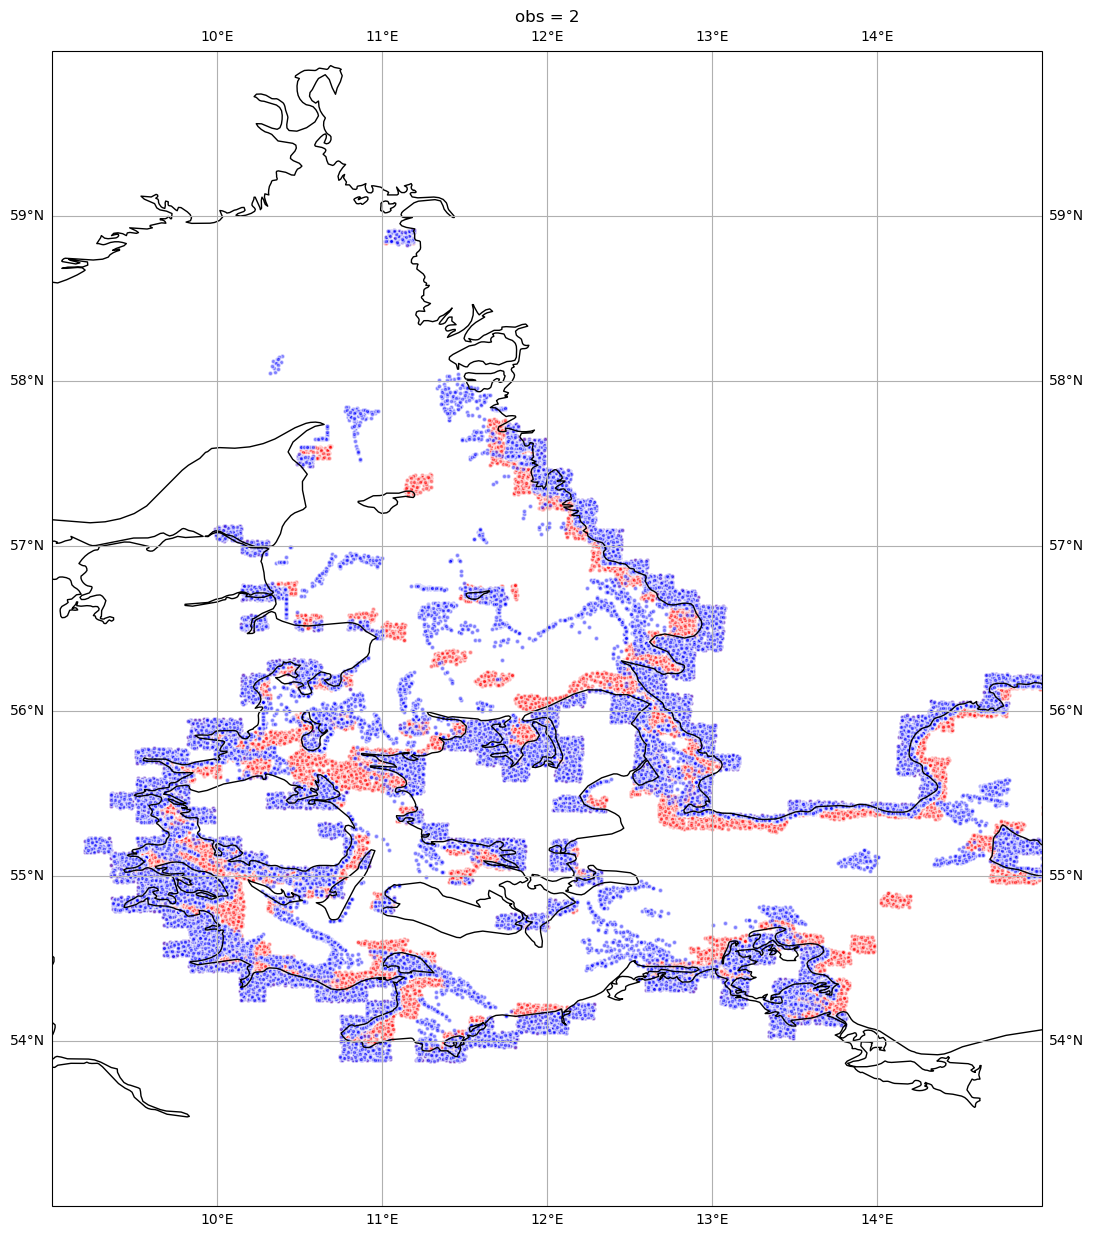

In [40]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
# ds_trajectories.isel(obs=12).plot.scatter(x="lon", y="lat", s=10, c="g", ax=ax, alpha=.5)
ds_trajectories.isel(obs=0).plot.scatter(x="lon", y="lat", s=10, c="r", ax=ax, alpha=.5)
ds_trajectories.isel(obs=2).plot.scatter(x="lon", y="lat", s=10, c="b", ax=ax, alpha=.5)
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.xlim(9,15)
plt.ylim(53,60)
plt.show()

IndexError: index 90 is out of bounds for axis 1 with size 28

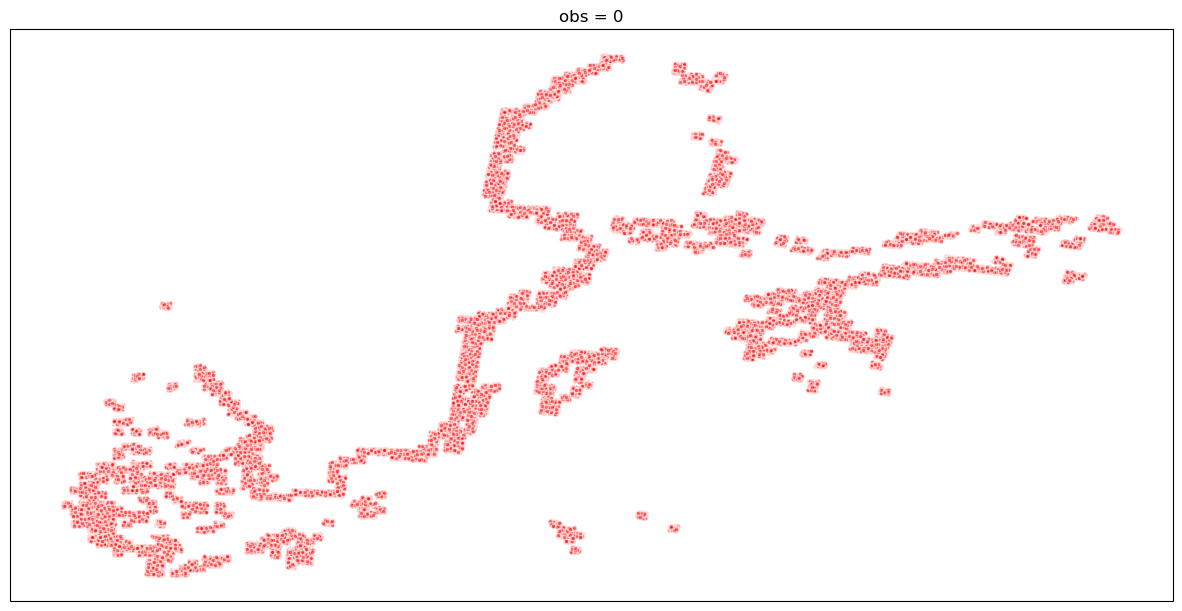

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ds_trajectories.isel(obs=0).plot.scatter(x="lon", y="lat", s=10, c="r", ax=ax, alpha=.5)
# ds_trajectories.isel(obs=90).plot.scatter(x="lon", y="lat", s=10, c="g", ax=ax, alpha=.5)
# ds_trajectories.isel(obs=170).plot.scatter(x="lon", y="lat", s=10, c="b", ax=ax, alpha=.5)
plt.show()

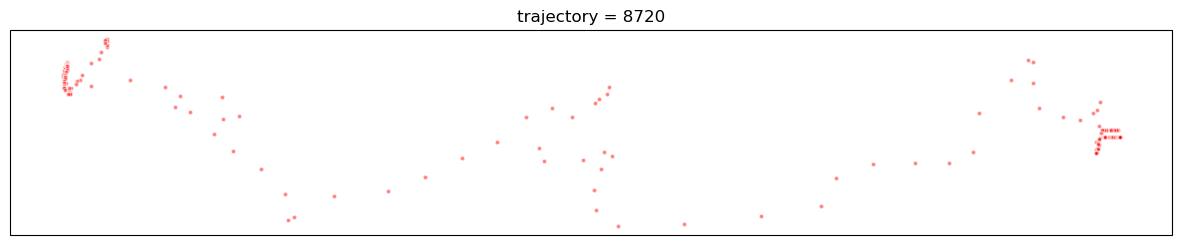

In [ ]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ds_trajectories.isel(trajectory=0).plot.scatter(x="lon", y="lat", s=10, c="r", ax=ax, alpha=.5)
# ds_trajectories.isel(obs=90).plot.scatter(x="lon", y="lat", s=10, c="g", ax=ax, alpha=.5)
# ds_trajectories.isel(obs=179).plot.scatter(x="lon", y="lat", s=10, c="b", ax=ax, alpha=.5)
plt.show()

## Time plots

In [ ]:
# for i in np.arange(ds_trajectories.trajectory.shape[0] / number_particles):
#     traj_i = int(i*number_particles)
#     plt.plot(
#         ds_trajectories.time.isel(trajectory=traj_i),
#         ds_trajectories.age_sec.isel(trajectory=traj_i) / 3600,
#     )
# plt.show()

In [ ]:
# ds_trajectories.age_day.plot()

## Maps

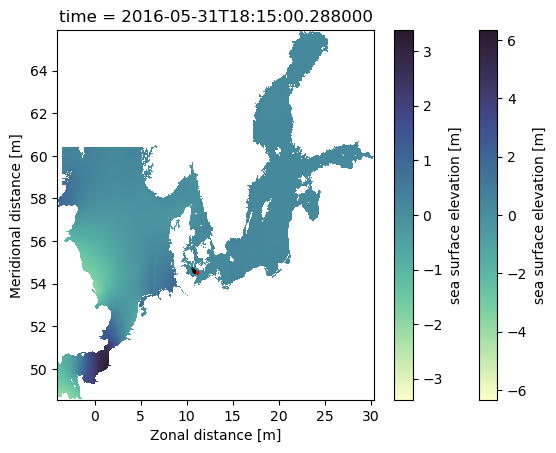

In [ ]:
# traj = ds_trajectories  # .isel(obs=671)#.isel(trajectory=6)
# # fieldset_NF
# # plt.pcolormesh(ds_eta_fine.elev.isel(time=0))
# ds_eta_fine.elev.isel(time=0).plot(
#     cmap=cmocean.cm.deep,
# )
# ds_eta_coarse.elev.isel(time=0).plot(
#     cmap=cmocean.cm.deep,
# )

# plt.scatter(
#     traj.lon,
#     traj.lat,
#     c="k",
#     s=0.00001,
# )
# plt.plot(
#     (
#         lon_release_max,
#         lon_release_max,
#         lon_release_min,
#         lon_release_min,
#         lon_release_max,
#     ),
#     (
#         lat_release_max,
#         lat_release_min,
#         lat_release_min,
#         lat_release_max,
#         lat_release_max,
#     ),
#     c="r",
# )
# # plt.xlim(7,27)
# # plt.ylim(53,60)
# plt.xlabel("Zonal distance [m]")
# plt.ylabel("Meridional distance [m]")
# plt.show()

In [41]:
first_lat = ds_trajectories.isel(obs=0).lat
first_lon = ds_trajectories.isel(obs=0).lon

In [42]:
last_valid_obs = ds_trajectories.obs.where(ds_trajectories.lon.notnull()).max('obs').astype(int)
last_step = ds_trajectories.isel(obs=last_valid_obs).compute()

last_lon = last_step.lon
last_lat = last_step.lat

last_step.to_dataframe().describe()

,S,T,cellcode,d,eta,h0,lat,lon,obs,time,u,v,wsigma,wz,z
count,87200.000000,87200.000000,87200.000000,87200.0,87200.000000,87200.000000,87200.000000,87200.000000,87200.0,87200,8.720000e+04,8.720000e+04,87200.0,87200.0,87200.0
mean,2.567836,0.905349,43599.500000,0.0,0.294642,11.840604,57.971011,17.390159,2.0,2016-01-02 14:44:59.712000,-3.895292e-07,4.216413e-07,0.0,0.0,0.0
min,0.000000,-1.390000,0.000000,0.0,-0.503000,-4.040000,53.879647,9.200033,2.0,2016-01-02 14:44:59.712000,-2.232502e-05,-1.903824e-06,0.0,0.0,0.0
25%,0.000000,0.000000,21799.750000,0.0,0.000000,0.000000,55.834723,12.578009,2.0,2016-01-02 14:44:59.712000,0.000000e+00,0.000000e+00,0.0,0.0,0.0
50%,0.000000,0.000000,43599.500000,0.0,0.294000,2.210000,58.100444,17.493615,2.0,2016-01-02 14:44:59.712000,0.000000e+00,0.000000e+00,0.0,0.0,0.0
75%,4.971877,0.245006,65399.250000,0.0,0.480000,11.240000,59.984009,21.513502,2.0,2016-01-02 14:44:59.712000,0.000000e+00,4.271781e-08,0.0,0.0,0.0
max,32.690002,7.492503,87199.000000,0.0,4.090000,305.416992,63.510369,28.778383,2.0,2016-01-02 14:44:59.712000,1.534843e-05,1.179361e-05,0.0,0.0,0.0
std,5.229196,1.779206,25172.529297,0.0,0.443960,23.318186,2.408389,5.069541,0.0,NaN,1.363296e-06,1.014588e-06,0.0,0.0,0.0


In [43]:
traj_moving = ds_trajectories.where(first_lon != last_lon, drop=True)
traj_moving

<xarray.Dataset> Size: 12MB
Dimensions:     (trajectory: 39029, obs: 4)
Coordinates:
  * obs         (obs) int32 16B 0 1 2 3
  * trajectory  (trajectory) int64 312kB 5 7 8 16 19 ... 87192 87193 87195 87196
Data variables: (12/14)
    S           (trajectory, obs) float32 624kB 6.863 6.94 7.19 ... 8.54 nan
    T           (trajectory, obs) float32 624kB 5.223 5.113 4.64 ... 2.768 nan
    cellcode    (trajectory, obs) float32 624kB 5.0 5.0 5.0 ... 8.72e+04 nan
    d           (trajectory, obs) float32 624kB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    eta         (trajectory, obs) float32 624kB 0.484 0.522 0.479 ... 0.543 nan
    h0          (trajectory, obs) float32 624kB 93.86 101.7 101.0 ... 7.382 nan
    ...          ...
    time        (trajectory, obs) datetime64[ns] 1MB 2016-01-01T14:44:59.7120...
    u           (trajectory, obs) float32 624kB -1.479e-06 -2.99e-06 ... nan
    v           (trajectory, obs) float32 624kB -1.011e-07 9.524e-07 ... nan
    wsigma      (trajectory, obs) float32 624kB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    wz          (trajectory, obs) float32 624kB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
    z           (trajectory, obs) float64 1MB 0.0 0.0 0.0 nan ... 0.0 0.0 nan
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        NewParticleAdvectionRK4_3D_SIGMABSH
    parcels_mesh:           spherical
    parcels_version:        3.0.6

IndexError: index 27 is out of bounds for axis 1 with size 4

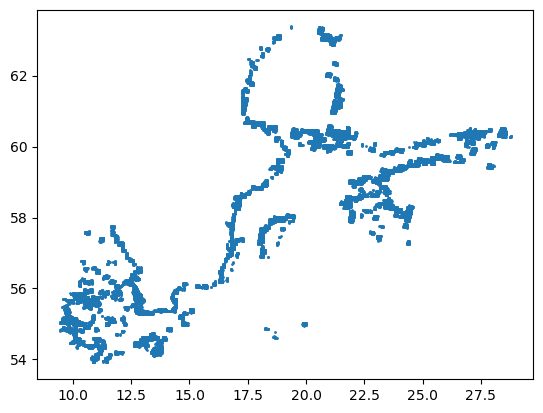

In [46]:
plt.scatter(traj_moving.lon.isel(obs=0), traj_moving.lat.isel(obs=0), s=1)
plt.scatter(traj_moving.lon.isel(obs=1), traj_moving.lat.isel(obs=27), s=1, c="r", alpha=.5)

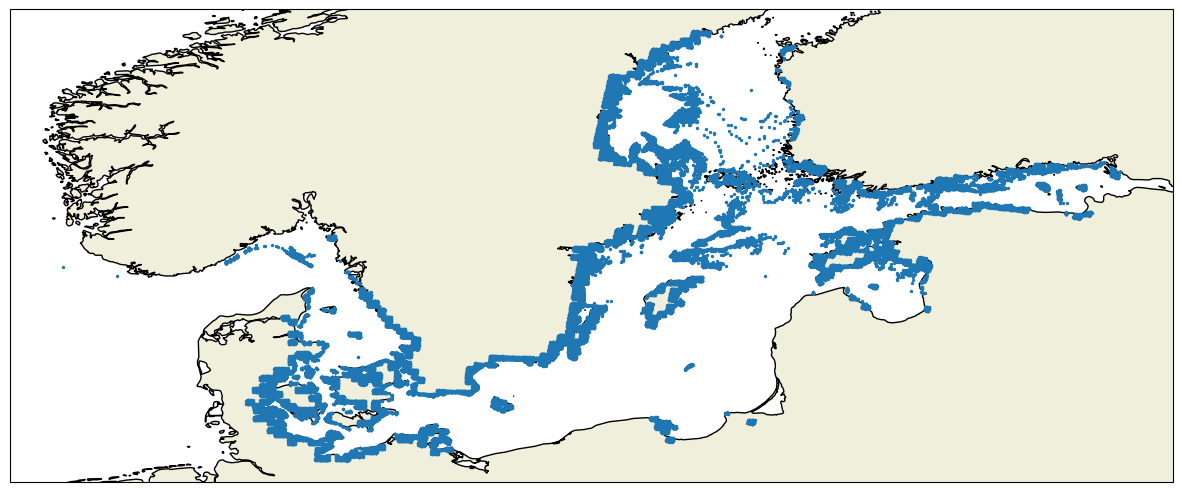

In [ ]:
fig = plt.figure(figsize=(15,12))
ax = fig.add_subplot(
    1,1,1,
    projection= ccrs.PlateCarree(),
)
ax.add_feature(cartopy.feature.LAND, edgecolor='k')
ax.scatter(
    last_lon,
    last_lat,
    transform=ccrs.Geodetic(),
    s=2,
)
plt.show()

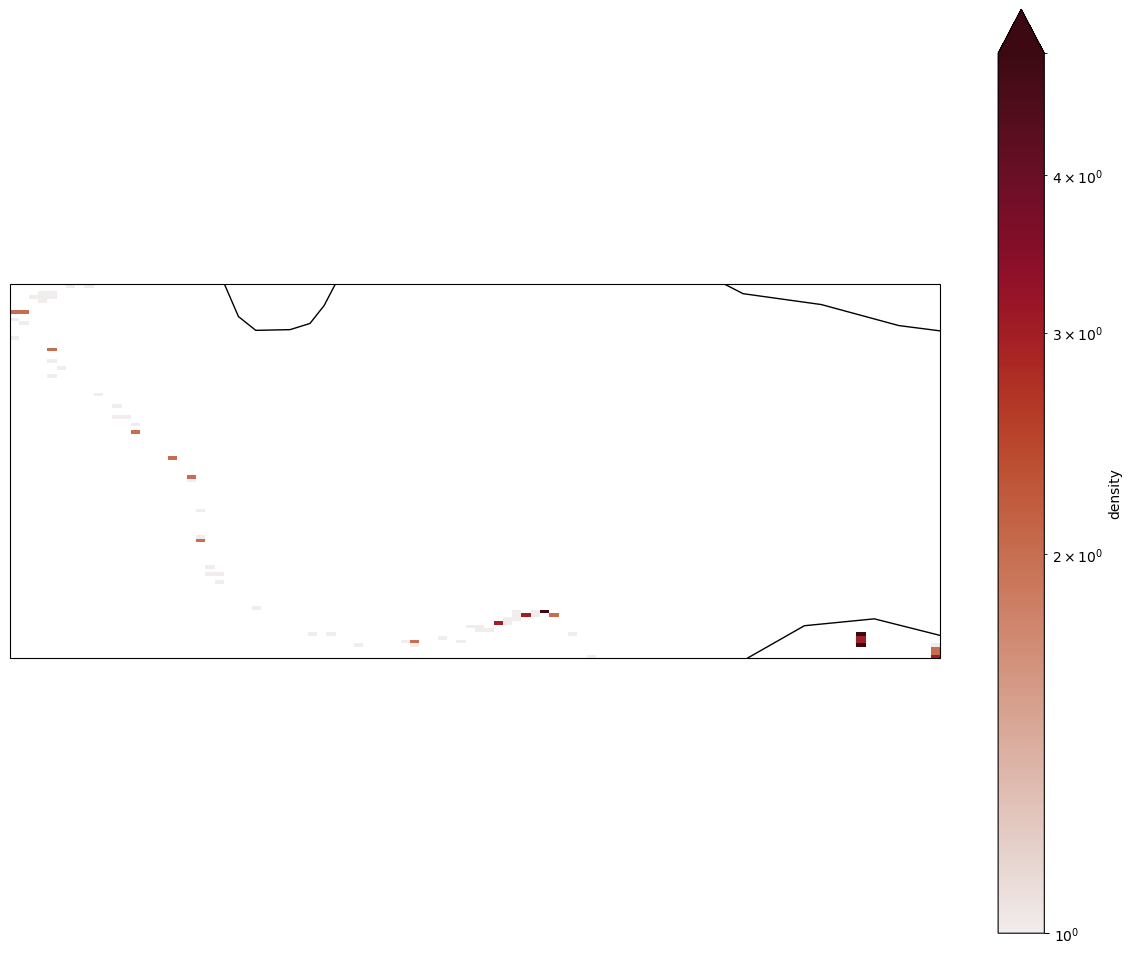

In [ ]:
fig, ax = plt.subplots(
    1,1,
    subplot_kw={'projection' : ccrs.PlateCarree()},
    figsize=(15,12),
)
ax.coastlines()
dense_plt = ax.hist2d(
    last_lon,
    last_lat,
    bins=[100, 100],
    norm=mcolors.LogNorm(),
    cmap=cmocean.cm.amp,
)
fig.colorbar(
    dense_plt[3],
    ax=ax,
    extend="max",
    label="density",
)
plt.show()